# Part 1 - Data Preprocessing

## Importing the libararies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Importing the training set

In [2]:
dataset_train = pd.read_csv('../input/google-stock-price/dataset/Google_Stock_Price_Train.csv')

### Checking first 5 records of the training set

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


### Checking for Null values 

In [4]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
dataset_train.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


#### Now we only select second column of the dataset_train which is **Open** and convert into numpy array using values method

In [6]:
training_set = dataset_train.iloc[:, 1:2].values

In [7]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [8]:
training_set.shape

(1258, 1)

## Feature Scaling
*  there are mainly two ways to feature scaling
   1. Standardisation  
   2. Normalization 
* in our case we gonna use normalization and specifically minmax scaler and the idea behind that is since we gonna create RNN and in this network we use sigmoid activation function in output layer.so it's great to values lies between 0 to 1 and minmax scaler exactly doing same

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

## Creating a data structure with 60 timesteps and 1 output
* we'll take 60 to timestamps, first of for whats timestemp? since we gonna predict stock price(Open) so timestamp of 60 is saying that when you predict stock price at any given day at that time consider last 60 days to make prediction.
* then we create 2 numpy array X_train and y_train where X_train is containing stock price with last 60 days stock price values and y_train containing single day stock price at given day.

In [10]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
    
#converting lists into numpy array for further procedure
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_train.shape

(1198, 60)

In [12]:
y_train.shape

(1198,)

## Reshaping
* we have to convert into standard format rnn format X_train into 3D tensor with shape(batch_size, timestemps, output_size)
* let's see each perameters values for our model
1. batch_size: No of Observation(X_train.shape[0] which is 1198)
2. timestems: 60 as we initialized above(X_train.shape[1])
3. input_dim: 1 since we gonna predict only one varibale google stock price

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [14]:
X_train.shape

(1198, 60, 1)

# Part 2 - Building the RNN


## Importing the keras libraries and packages

In [15]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Initializing the RNN

In [16]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

* units : number of neurons we choose 60
* return_sequences: choose **True** because we are gonna add another lstm layer after this one
* input_shape: it will take 2d array(timestemps and indicator(no of predictor) and the value would be **(X_train.shape[1], 1)**
* Dropout Layer : we give it to 0.1 means 10%, that means drop the 10 percent(6 neurons) of neurons which are least involving.
* **NOTE**: Dropout is used to Prevent **Overfitting**

In [17]:
regressor.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding the second LSTM layer and some Dropout regularisation
* after first lstm layer we dont need to specify input_shape

In [18]:
regressor.add(LSTM(units=60, return_sequences= True))
regressor.add(Dropout(0.2))

### Adding the third LSTM layer and some Dropout regularisation


In [19]:
regressor.add(LSTM(units=60, return_sequences=True))
regressor.add(Dropout(0.2))

### Adding the fourth LSTM layer and some Dropout regularisation
* we don't have to specify return_sequences in last lstm layer since it by default false.

In [20]:
regressor.add(LSTM(units=60))
regressor.add(Dropout(0.1))

## Adding the output layer
* units: 1 since we predict only one value

In [21]:
regressor.add(Dense(1))

## Compiling the RNN

* optimizer: **adam** is always a safe choice or you can use **RMSprop** which is also a good choice for RNN
* loss: since we have a regression problem we gonna use **mean_squared_error**

In [22]:
opt = keras.optimizers.Adam(learning_rate=0.001)
regressor.compile(optimizer=opt, loss='mean_squared_error')

## Fitting the RNN to the Training set

In [23]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 11s 122ms/step - loss: 0.0846
Epoch 2/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0042
Epoch 3/100
38/38 [==============================] - 5s 128ms/step - loss: 0.0043
Epoch 4/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0040
Epoch 5/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0041
Epoch 6/100
38/38 [==============================] - 5s 122ms/step - loss: 0.0037
Epoch 7/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0032
Epoch 8/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0029
Epoch 10/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0033
Epoch 11/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0028
Epoch 12/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0029
Epoch 13/100

# Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017 which we gonna predict

In [24]:
dataset_test = pd.read_csv('../input/google-stock-price/dataset/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of jan 2017
### 3 Key Points
1. we trained our model to be able to predict the stock price at time t+1 based on the 60 previous stock prices and therefore to predict each stock price of each financial day of January, 2017 we will need 60 previous stock prices of the 60 previous financial days, before the actual day.
2. in order to get day of january,2017 the 60 previous stock prices of the 60 previous day, so we will need both the train set and test set because we will have some of the 60 days that will be from the testing set because they will be form november 2016 and we will also have some stock prices of the test set because some of them will come from january 2017, and therefore first thing we need to do now is now some concatenation of training set and test set to be able to get these 60 previous inputs for each day of january, 2017.
3. we will have to concatenate both but we do not change the actual test values. so we have to concatenate orininal dataset.(we have to feed our model with scaling values but make prediction on actual values so we have to keep them)

In [25]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [26]:
predicted_stock_price

array([[791.09717],
       [788.39984],
       [789.79254],
       [791.2574 ],
       [794.4802 ],
       [800.41785],
       [804.89777],
       [805.7184 ],
       [805.9358 ],
       [806.47974],
       [807.0171 ],
       [807.1228 ],
       [807.07043],
       [807.80615],
       [808.7514 ],
       [814.20557],
       [821.0934 ],
       [827.57355],
       [829.8994 ],
       [823.73486]], dtype=float32)

## Visualizing the Result

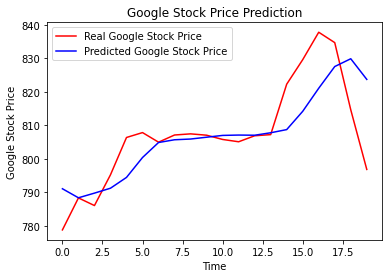

In [27]:
plt.plot(real_stock_price, color='red', label="Real Google Stock Price")
plt.plot(predicted_stock_price, color="blue", label="Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()